# Exploratory Drug Label Analysis, OpenFDA

This course will focus on manipulating mostly-structured text data, and trying to plot interesting things to help guide our analysis.  Ultimately, this analysis is about clustering: how to appropriately group drugs based on all sorts of different metrics.  Before we pull out the big guns (heavy ML-based clustering algorithms), let's see what we can expect by opening up the data and playing around.

In [15]:
%matplotlib inline  
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,8)

import os
import pprint
import json
import lxml.etree as etree
import pandas as pd
from pandas.io.json import json_normalize
pprint = pprint.pprint #Set up pretty print

In [2]:
data = json.load(open('../test_data/drug-label-0001-of-0007.json'))
print(data.keys())
data['meta']

dict_keys(['meta', 'results'])


{'disclaimer': 'Do not rely on openFDA to make decisions regarding medical care. While we make every effort to ensure that data is accurate, you should assume all results are unvalidated. We may limit or otherwise restrict your access to the API in line with our Terms of Service.',
 'last_updated': '2018-12-14',
 'license': 'https://open.fda.gov/license/',
 'results': {'limit': 20000, 'skip': 0, 'total': 131198},
 'terms': 'https://open.fda.gov/terms/'}

In [3]:
#df = pd.DataFrame(data['results'])
df = json_normalize(data['results'])
pprint(df.columns)
with pd.option_context('display.max_columns', 160):
    display(df.head())

Index(['abuse', 'accessories', 'active_ingredient', 'active_ingredient_table',
       'adverse_reactions', 'adverse_reactions_table',
       'animal_pharmacology_and_or_toxicology', 'ask_doctor',
       'ask_doctor_or_pharmacist', 'ask_doctor_or_pharmacist_table',
       ...
       'use_in_specific_populations_table', 'user_safety_warnings', 'version',
       'veterinary_indications', 'warnings', 'warnings_and_cautions',
       'warnings_and_cautions_table', 'warnings_table', 'when_using',
       'when_using_table'],
      dtype='object', length=153)


,abuse,accessories,active_ingredient,active_ingredient_table,adverse_reactions,adverse_reactions_table,animal_pharmacology_and_or_toxicology,ask_doctor,ask_doctor_or_pharmacist,ask_doctor_or_pharmacist_table,ask_doctor_table,assembly_or_installation_instructions,boxed_warning,boxed_warning_table,calibration_instructions,carcinogenesis_and_mutagenesis_and_impairment_of_fertility,carcinogenesis_and_mutagenesis_and_impairment_of_fertility_table,cleaning,clinical_pharmacology,clinical_pharmacology_table,clinical_studies,clinical_studies_table,components,contraindications,contraindications_table,controlled_substance,dependence,description,description_table,do_not_use,do_not_use_table,dosage_and_administration,dosage_and_administration_table,dosage_forms_and_strengths,dosage_forms_and_strengths_table,drug_abuse_and_dependence,drug_abuse_and_dependence_table,drug_and_or_laboratory_test_interactions,drug_interactions,drug_interactions_table,effective_time,environmental_warning,general_precautions,general_precautions_table,geriatric_use,geriatric_use_table,health_care_provider_letter,health_care_provider_letter_table,how_supplied,how_supplied_table,id,inactive_ingredient,inactive_ingredient_table,indications_and_usage,indications_and_usage_table,information_for_owners_or_caregivers,information_for_patients,information_for_patients_table,instructions_for_use,instructions_for_use_table,intended_use_of_the_device,keep_out_of_reach_of_children,keep_out_of_reach_of_children_table,labor_and_delivery,laboratory_tests,laboratory_tests_table,mechanism_of_action,mechanism_of_action_table,microbiology,microbiology_table,nonclinical_toxicology,nonclinical_toxicology_table,nonteratogenic_effects,nonteratogenic_effects_table,nursing_mothers,openfda.application_number,openfda.brand_name,openfda.generic_name,openfda.is_original_packager,openfda.manufacturer_name,openfda.nui,openfda.original_packager_product_ndc,openfda.package_ndc,openfda.pharm_class_cs,openfda.pharm_class_epc,openfda.pharm_class_moa,openfda.pharm_class_pe,openfda.product_ndc,openfda.product_type,openfda.route,openfda.rxcui,openfda.spl_id,openfda.spl_set_id,openfda.substance_name,openfda.unii,openfda.upc,other_safety_information,overdosage,overdosage_table,package_label_principal_display_panel,package_label_principal_display_panel_table,patient_medication_information,patient_medication_information_table,pediatric_use,pediatric_use_table,pharmacodynamics,pharmacodynamics_table,pharmacogenomics,pharmacokinetics,pharmacokinetics_table,precautions,precautions_table,pregnancy,pregnancy_or_breast_feeding,pregnancy_table,purpose,purpose_table,questions,questions_table,recent_major_changes,recent_major_changes_table,references,risks,safe_handling_warning,safe_handling_warning_table,set_id,spl_medguide,spl_medguide_table,spl_patient_package_insert,spl_patient_package_insert_table,spl_product_data_elements,spl_unclassified_section,spl_unclassified_section_table,statement_of_identity,statement_of_identity_table,stop_use,stop_use_table,storage_and_handling,storage_and_handling_table,teratogenic_effects,teratogenic_effects_table,troubleshooting,use_in_specific_populations,use_in_specific_populations_table,user_safety_warnings,version,veterinary_indications,warnings,warnings_and_cautions,warnings_and_cautions_table,warnings_table,when_using,when_using_table
0,NaN,NaN,[HPUS Active Ingredients Each dose contains eq...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[Directions Initially depress pump until prime...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20160323,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2eb93d7c-3310-4b93-e054-00144ff88e88,"[Citric acid, potassium sorbate, purified water.]",NaN,"[Uses Homeopathic remedy for distractability, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,[Keep this and all medication out of reach of ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[BrightSpark],"[ARG NIT, ARSENICUM IOD, HYOSCYAMUS, VERATRUM ...",[True],[S

I think we might be able to work with this now.  We've used `json_normalize` to flatten the semi-structured format into something tabular.  There are 153 column labels, but we'll want to drop a bunch and just use a subset for now. I want to just look at the 'openfda' subset of columns, as it looks like there's some useful info there (https://open.fda.gov/apis/openfda-fields/).

In [4]:
df_openfda = df.filter(regex='openfda*')
print(df_openfda.columns, len(df_openfda.columns))
with pd.option_context('display.max_columns', 25):
    display(df_openfda.head())

Index(['openfda.application_number', 'openfda.brand_name',
       'openfda.generic_name', 'openfda.is_original_packager',
       'openfda.manufacturer_name', 'openfda.nui',
       'openfda.original_packager_product_ndc', 'openfda.package_ndc',
       'openfda.pharm_class_cs', 'openfda.pharm_class_epc',
       'openfda.pharm_class_moa', 'openfda.pharm_class_pe',
       'openfda.product_ndc', 'openfda.product_type', 'openfda.route',
       'openfda.rxcui', 'openfda.spl_id', 'openfda.spl_set_id',
       'openfda.substance_name', 'openfda.unii', 'openfda.upc'],
      dtype='object') 21


,openfda.application_number,openfda.brand_name,openfda.generic_name,openfda.is_original_packager,openfda.manufacturer_name,openfda.nui,openfda.original_packager_product_ndc,openfda.package_ndc,openfda.pharm_class_cs,openfda.pharm_class_epc,openfda.pharm_class_moa,openfda.pharm_class_pe,openfda.product_ndc,openfda.product_type,openfda.route,openfda.rxcui,openfda.spl_id,openfda.spl_set_id,openfda.substance_name,openfda.unii,openfda.upc
0,NaN,[BrightSpark],"[ARG NIT, ARSENICUM IOD, HYOSCYAMUS, VERATRUM ...",[True],[Silver Star Brands],NaN,NaN,[68703-252-02],NaN,NaN,NaN,NaN,[68703-252],[HUMAN OTC DRUG],[ORAL],NaN,[2eb93d7c-3310-4b93-e054-00144ff88e88],[2eb93d7c-330f-4b93-e054-00144ff88e88],"[VERATRUM ALBUM ROOT, HYOSCYAMUS NIGER, SILVER...","[QNS6W5US1Z, 3029988O2T, 95IT3W8JZE, 4WRK2153H3]",[0818837012253]
1,[part347],[Aveeno Baby Eczema Therapy Soothing Bath Trea...,[OATMEAL],[True],[Johnson & Johnson Consumer Inc.],"[N0000185016, N0000175629, N0000008246, N00001...",NaN,[69968-0199-5],"[Grain Proteins [Chemical/Ingredient], Dietary...",[Non-Standardized Food Allergenic Extract [EPC...,NaN,"[Cell-mediated Immunity [PE], Increased Histam...",[69968-0199],[HUMAN OTC DRUG],[TOPICAL],NaN,[ae390f8a-fdf1-4711-9943-e1a46e2ef0e8],[7f689b72-ccfb-4ae0-9747-1490593998ca],[OATMEAL],[8PI54V663Y],NaN
2,[ANDA203646],[levocetirizine dihydrochloride],[LEVOCETIRIZINE DIHYDROCHLORIDE],NaN,[Proficient Rx LP],NaN,[42543-712],"[63187-663-60, 63187-663-90, 63187-663-30]",NaN,NaN,NaN,NaN,[63187-663],[HUMAN PRESCRIPTION DRUG],[ORAL],[855172],[b84ccb27-9c52-43b9-9a46-8f52a571045e],[b84ccb27-9c52-43b9-9a46-8f52a571045e],[LEVOCETIRIZINE DIHYDROCHLORIDE],[SOD6A38AGA],NaN
3,[ANDA091009],[Good Neighbor Pharmacy Mucus ER],[GUAIFENESIN],[True],[Amerisource Bergen],NaN,NaN,[46122-351-74],NaN,NaN,NaN,NaN,[46122-351],[HUMAN OTC DRUG],[ORAL],[310621],[1e99f1a3-95bc-4108-8395-430a32c4f292],[1e99f1a3-95bc-4108-8395-430a32c4f292],[GUAIFENESIN],[495W7451VQ],NaN
4,[ANDA076549],[Ramipril],[RAMIPRIL],NaN,[Proficient Rx LP],"[N0000175562, N0000000181]",[16252-572],"[63187-675-30, 63187-675-90, 63187-675-60]",NaN,[Angiotensin Converting Enzyme Inhibitor [EPC]],[Angiotensin-converting Enzyme Inhibitors [MoA]],NaN,[63187-675],[HUMAN PRESCRIPTION DRUG],[ORAL],[198189],[4146cfc6-2b02-4731-a0f1-8c445bafea55],[4146cfc6-2b02-4731-a0f1-8c445bafea55],[RAMIPRIL],[L35JN3I7SJ],NaN


Ok, looking good.  Before we play with the data, we have to clean it up.  Are these brackets strings that were parsed wrong or actual list objects?

In [5]:
print(df_openfda.iloc[0][1])
type(df_openfda.iloc[0][1])

['BrightSpark']


list

That answers that.  I don't want a bunch of lists for anything that's a single item, so lets unpack all lists of length=1.  Lets also strip 'openfda' off of our columns.

In [6]:
df_openfda = df_openfda.applymap(lambda x: x[0] if type(x) is list and len(x)==1 else x)
df_openfda.columns = df_openfda.columns.str.replace('openfda.','')

In [7]:
df_openfda.head()

,application_number,brand_name,generic_name,is_original_packager,manufacturer_name,nui,original_packager_product_ndc,package_ndc,pharm_class_cs,pharm_class_epc,...,pharm_class_pe,product_ndc,product_type,route,rxcui,spl_id,spl_set_id,substance_name,unii,upc
0,NaN,BrightSpark,"ARG NIT, ARSENICUM IOD, HYOSCYAMUS, VERATRUM ALB",True,Silver Star Brands,NaN,NaN,68703-252-02,NaN,NaN,...,NaN,68703-252,HUMAN OTC DRUG,ORAL,NaN,2eb93d7c-3310-4b93-e054-00144ff88e88,2eb93d7c-330f-4b93-e054-00144ff88e88,"[VERATRUM ALBUM ROOT, HYOSCYAMUS NIGER, SILVER...","[QNS6W5US1Z, 3029988O2T, 95IT3W8JZE, 4WRK2153H3]",0818837012253
1,part347,Aveeno Baby Eczema Therapy Soothing Bath Treat...,OATMEAL,True,Johnson & Johnson Consumer Inc.,"[N0000185016, N0000175629, N0000008246, N00001...",NaN,69968-0199-5,"[Grain Proteins [Chemical/Ingredient], Dietary...",[Non-Standardized Food Allergenic Extract [EPC...,...,"[Cell-mediated Immunity [PE], Increased Histam...",69968-0199,HUMAN OTC DRUG,TOPICAL,NaN,ae390f8a-fdf1-4711-9943-e1a46e2ef0e8,7f689b72-ccfb-4ae0-9747-1490593998ca,OATMEAL,8PI54V663Y,NaN
2,ANDA203646,levocetirizine dihydrochloride,LEVOCETIRIZINE DIHYDROCHLORIDE,NaN,Proficient Rx LP,NaN,42543-712,"[63187-663-60, 63187-663-90, 63187-663-30]",NaN,NaN,...,NaN,63187-663,HUMAN PRESCRIPTION DRUG,ORAL,855172,b84ccb27-9c52-43b9-9a46-8f52a571045e,b84ccb27-9c52-43b9-9a46-8f52a571045e,LEVOCETIRIZINE DIHYDROCHLORIDE,SOD6A38AGA,NaN
3,ANDA091009,Good Neighbor Pharmacy Mucus ER,GUAIFENESIN,True,Amerisource Bergen,NaN,NaN,46122-351-74,NaN,NaN,...,NaN,46122-351,HUMAN OTC DRUG,ORAL,310621,1e99f1a3-95bc-4108-8395-430a32c4f292,1e99f1a3-95bc-4108-8395-430a32c4f292,GUAIFENESIN,495W7451VQ,NaN
4,ANDA076549,Ramipril,RAMIPRIL,NaN,Proficient Rx LP,"[N0000175562, N0000000181]",16252-572,"[63187-675-30, 63187-675-90, 63187-675-60]",NaN,Angiotensin Converting Enzyme Inhibitor [EPC],...,NaN,63187-675,HUMAN PRESCRIPTION DRUG,ORAL,198189,4146cfc6-2b02-4731-a0f1-8c445bafea55,4146cfc6-2b02-4731-a0f1-8c445bafea55,RAMIPRIL,L35JN3I7SJ,NaN


Excellent.  I want to reindex on something unique as well, ideally an identifier for the drug.  We should figure out some basics about each column before we use it as an index (or do anything with it, really) 

In [46]:
for col in df_openfda:
    try:
        display(df_openfda[col].describe())
    except TypeError:
        print(col, 'cannot be described')

count       15942
unique       2088
top       part352
freq         3496
Name: application_number, dtype: object

count      20000
unique     14073
top       Oxygen
freq         127
Name: brand_name, dtype: object

count       20000
unique       4877
top       ALCOHOL
freq          650
Name: generic_name, dtype: object

count     16920
unique        1
top        True
freq      16920
Name: is_original_packager, dtype: object

count                                           20000
unique                                           3601
top       Rxhomeo Private Limited d.b.a. Rxhomeo, Inc
freq                                              565
Name: manufacturer_name, dtype: object

nui cannot be described
original_packager_product_ndc cannot be described
package_ndc cannot be described
pharm_class_cs cannot be described
pharm_class_epc cannot be described
pharm_class_moa cannot be described
pharm_class_pe cannot be described
product_ndc cannot be described


count              20000
unique                 2
top       HUMAN OTC DRUG
freq               15851
Name: product_type, dtype: object

route cannot be described
rxcui cannot be described


count                                    20000
unique                                   20000
top       9c8aa994-6715-471d-9fc7-b88d21eec369
freq                                         1
Name: spl_id, dtype: object

count                                    20000
unique                                   20000
top       3f78386f-42f1-22a9-1f27-349381dad0b0
freq                                         1
Name: spl_set_id, dtype: object

substance_name cannot be described
unii cannot be described
upc cannot be described


Only two columns are completely unique and do not contain lists: spl_id and spl_set_id.  Brand Names is not unique, but it's close.  Apparently a lot of companies make 'Oxygen'.  Good, I'm a firm believer that oxygen is important.  Let's take a look.

In [8]:
df_openfda[df_openfda.brand_name == 'Oxygen']

,application_number,brand_name,generic_name,is_original_packager,manufacturer_name,nui,original_packager_product_ndc,package_ndc,pharm_class_cs,pharm_class_epc,...,pharm_class_pe,product_ndc,product_type,route,rxcui,spl_id,spl_set_id,substance_name,unii,upc
1275,NaN,Oxygen,OXYGEN,True,Central Medical Supply,NaN,NaN,"[70058-001-03, 70058-001-02, 70058-001-01, 700...",NaN,NaN,...,NaN,70058-001,HUMAN PRESCRIPTION DRUG,RESPIRATORY (INHALATION),312172,e64c669a-ac38-491b-9f86-b7f8500cabb3,54b8414f-4559-4ded-bc40-9f30250a2c5e,OXYGEN,S88TT14065,NaN
1411,NaN,Oxygen,OXYGEN,True,Care Home Medical,NaN,NaN,"[55858-123-10, 55858-123-11, 55858-123-12, 558...",NaN,NaN,...,NaN,55858-123,HUMAN PRESCRIPTION DRUG,RESPIRATORY (INHALATION),312172,25ed22e2-f190-4ba5-e054-00144ff88e88,25ed22e2-f18f-4ba5-e054-00144ff88e88,OXYGEN,S88TT14065,NaN
2173,NaN,Oxygen,OXYGEN,True,OxyAir Medical LLC,NaN,NaN,25251-123-01,NaN,NaN,...,NaN,25251-123,HUMAN PRESCRIPTION DRUG,RESPIRATORY (INHALATION),312172,23e59ddd-19cb-564c-e054-00144ff8d46c,23e59ddd-19c9-564c-e054-00144ff8d46c,OXYGEN,S88TT14065,NaN
2540,NDA205865,Oxygen,OXYGEN,True,"J & M CYLINDER GASES, INC.",NaN,NaN,"[63862-001-02, 63862-001-03, 63862-001-01, 638...",NaN,NaN,...,NaN,63862-001,HUMAN PRESCRIPTION DRUG,RESPIRATORY (INHALATION),312173,61d0cf43-faf0-2c08-e053-2a91aa0a6d62,61d0cf43-faef-2c08-e053-2a91aa0a6d62,OXYGEN,S88TT14065,NaN
2590,NaN,Oxygen,OXYGEN,True,Advanced Home Care,NaN,NaN,"[55813-123-06, 55813-123-07, 55813-123-04, 558...",NaN,NaN,...,NaN,55813-123,HUMAN PRESCRIPTION DRUG,RESPIRATORY (INHALATION),312172,23bde802-d853-1ecc-e054-00144ff88e88,23be7076-e6b1-3465-e054-00144ff88e88,OXYGEN,S88TT14065,NaN
2789,NaN,Oxygen,OXYGEN,True,Camelot Healthcare Management Inc. dba Suncare...,NaN,NaN,"[67365-001-02, 67365-001-03, 67365-001-01]",NaN,NaN,...,NaN,67365-001,HUMAN PRESCRIPTION DRUG,RESPIRATORY (INHALATION),312172,db0ede99-c87b-4148-a67e-34fdf24c4c90,2cd9fef5-886e-4424-9941-a3b37237d5ec,OXYGEN,S88TT14065,NaN
3502,NaN,Oxygen,OXYGEN,True,"Metz Medical, Inc",NaN,NaN,"[66767-999-07, 66767-999-06, 66767-999-05, 667...",NaN,NaN,...,NaN,66767-999,HUMAN PRESCRIPTION DRUG,RESPIRATORY (INHALATION),542304,7c61f218-66e2-4fbd-9104-b12db26519ab,0692a78a-76d8-4fab-bd97-1d286a91715f,OXYGEN,S88TT14065,NaN
3848,NDA205849,Oxygen,OXYGEN,True,"Praxair Distribution Mid-atlantic, Llc",NaN,NaN,"[76133-001-16, 76133-001-17, 76133-001-14, 761...",NaN,NaN,...,NaN,76133-001,HUMAN PRESCRIPTION DRUG,RESPIRATORY (INHALATION),312172,92609b03-2aea-4683-9d12-35558c7b46a6,b5e6912a-2e42-4256-bd66-66cbd56ed42c,OXYGEN,S88TT14065,NaN
4210,NaN,Oxygen,OXYGEN,True,Stateserv Medical of Arizona,NaN,NaN,"[69216-001-04, 69216-001-01, 69216-001-03, 692...",NaN,NaN,...,NaN,69216-001,HUMAN PRESCRIPTION DRUG,RESPIRATORY (INHALATION),312172,e2363d79-3c6d-479d-9e3a-ff61b8bec029,2c7d9444-0ed3-4710-836b-1706e2b6a9cb,OXYGEN,S88TT14065,NaN
4493,NaN,Oxygen,OXYGEN,True,Oxygen Plus,NaN,NaN,"[67773-001-05, 67773-001-04, 67773-001-01, 677...",NaN,NaN,...,NaN,67773-001,HUMAN PRESCRIPTION DRUG,RESPIRATORY (INHALATION),312172,74a33f6c-5ef3-411f-b352-daf82eb3ea1c,f6592a30-b2f6-4086-8d12-532c4de68fe6,OXYGEN,S88TT14065,NaN


Ok, what if we multiindex this a bit, just to make things more readable or organized.  How about, generic->brand?

In [9]:
print(df_openfda.generic_name.isnull().any())
print(df_openfda.brand_name.isnull().any())
print(df_openfda.spl_id.isnull().any())

False
False
False


In [10]:
df_openfda.set_index(['generic_name','brand_name']).sort_index()

application_number  \
generic_name                                       brand_name                                             
.ALPHA.-KETOGLUTARIC ACID - AMBERGRIS - ANAMIRT... GUNA-DIZZY                                       NaN   
.GAMMA.-AMINOBUTYRIC ACID                          Gongjinhyang Qi and Jin Eye                      NaN   
1.85% HYDROCORTISONE ACETATE - 1.15% PRAMOXINE ... PROCORT                                          NaN   
38 BIOTECH LABORATORY LLC                          Chitoprex 101                                    NaN   
5-HYDROXYTRYPTOPHAN                                5-HTP Phenolic                                   NaN   
50 REMEDY KIT                                      Homeopathic Remedy Kit 30c                       NaN   
62% ETHYL ALCOHOL                                  Hand Sanitizer Orange with aloe             part333A   
                                                   hand sanitizer orange with aloe             part333A   
ABACAVIR SULFATE                                   Abacavir Sulfate                          ANDA091294   
                                                   ZIAGEN                                     NDA020977   
ABACAVIR SULFATE AND LAMIVUDINE                    EPZICOM                                    NDA021652   
ABACAVIR SULFATE, LAMIVUDINE, AND ZIDOVUDINE       TRIZIVIR                                   NDA021205   
ABELMOSCHUS                                        ABELMOSCHUS                                      NaN   
ABIES CANADENSIS                                   ABIES CANADENSIS                                 NaN   
                                                   ABIES CANADENSIS                                 NaN   
ABIES CANADENSIS, ALLIUM CEPA, ALLIUM SATIVUM, ... Kids Candida Relief                              NaN   
ABIES NIGRA                                        ABIES NIGRA                                      NaN   
                                                   ABIES NIGRA                                      NaN   
ABIES NIGRA, ANTIMONIUM CRUDUM, ASAFOETIDA, BAP... Yeast Freee                                      NaN   
ABIES NIGRA, ARSENICUM ALBUM, CONDURANGO, CONIU... Heartburn Relief                                 NaN   
ABIES NIGRA, CONDURANGO, CONIUM MACULATUM, IRIS... HeartburnCare                                    NaN   
ABROTANUM                                          ABROTANUM                                        NaN   
                                                   ABROTANUM                                        NaN   
                                                   ABROTANUM                                        NaN   
ABROTANUM (ARTEMISIA ABROTANUM), ANACARDIUM ORI... Ultra Advantage                                  NaN   
ABROTANUM, ADRENALINUM, ADRENOCORTICOTROPHIN, A... Anti Aging and Wrinkles For Women                NaN   
ABROTANUM, AESCULUS HIPP., ALLIUM SATIVUM, ARSE... Parasites                                        NaN   
ABROTANUM, ANACARDIUM ORIENTALE, ARSENICUM ALBU... Anti-Aging and Wrinkles                          NaN   
ABROTANUM, ANACARDIUM ORIENTALE, BARYTA CARBONI... SWL ULTRA ADVANTAGE                              NaN   
ABROTANUM, ANACARDIUM ORIENTALE, BARYTA MURIATI... ADVANTAGE                                        NaN   
...                                                                                                 ...   
ZOLPIDEM TARTRATE                                  ZOLPIDEM TARTRATE                         ANDA077903   
                                                   ZOLPIDEM TARTRATE                         ANDA077903   
                                                   ZOLPIDEM TARTRATE                         ANDA078426   
                                                   ZOLPIDEM TARTRATE                         ANDA077903   
                                                   ZOLPIDEM TARTRATE                         ANDA077903   
                   

It's something, at least.  I'm not sure we want to make the kind of distinctions like 62% Ethyl Alcohol vs... how many ethyls do we have?

In [11]:
df_openfda.set_index(['generic_name','brand_name']).sort_index().filter(regex=r'\bETHYL\b', axis=0)

application_number  \
generic_name                           brand_name                                                              
62% ETHYL ALCOHOL                      Hand Sanitizer Orange with aloe                              part333A   
                                       hand sanitizer orange with aloe                              part333A   
ALCOHOL                                ETHYL ALCOHOL                                                 part333   
                                       ETHYL ALCOHOL                                                 part333   
                                       ETHYL ALCOHOL                                                 part333   
                                       ETHYL ALCOHOL                                                 part333   
                                       ETHYL ALCOHOL                                                 part333   
CHLORHEXIDINE GLUCONATE, ETHYL ALCOHOL Purmist                                                       part333   
                                       Purmist                                                       part333   
ETHYL ALCOHOL                          2-Pack Hand Sanitizer                                        part333E   
                                       ANTI BACTERIAL HAND SANITIZER                                part333E   
                                       ANTI BACTERIAL HAND SANITIZER                                part333E   
                                       ANTI BACTERIAL HAND SANITIZER                                part333E   
                                       ANTI BACTERIAL HAND SANITIZER                                part333E   
                                       ANTI BACTERIAL HAND SANITIZER                                part333E   
                                       ANTI BACTERIAL HAND SANITIZER                                part333E   
                                       ANTI BACTERIAL HAND SANITIZER                                part333E   
                                       ANTI BACTERIAL HAND SANITIZER                                part333E   
                                       ANTI BACTERIAL HAND SANITIZER                                part333E   
                                       ANTI BACTERIAL HAND SANITIZER                                part333E   
                                       ANTI BACTERIAL HAND SANITIZER                                part333E   
                                       ANTI BACTERIAL HAND SANITIZER                                part333E   
                                       ANTI-AGING HAND SANITIZER                                    part333E   
                                       ANTIBACTERIAL HAND SANITIZER BASIL AND GREEN TEA             part333E   
                                       ANTIBACTERIAL SANITIZER                                      part333E   
                                       AURORA ANTIBACTERIAL SANITIZER SUMMER COTTON BR...           part333E   
                                       AURORA ANTIBACTERIAL SANITIZER SWEET LYCHEE BERRY            part333E   
                                       Advanced                                                     part333A   
                                       Advanced                                                     part333A   
                                       AmeriDerm Foam Alcohol Hand Sanitizer                        part333E   
...                                                                                                      ...   
                                       anti-bacterial hand sanitizer                                part333E   
                                       anti-bacterial hand sanitizer                                part333E   
                                       anti-bacterial hand sanitizer                                part333E   
                                       bubble gum         

We'll want to group these drugs somehow, and plot our grouping.  First, let's see what kind of basic categories we can make with just the info here in the `df_openfda` dataset.

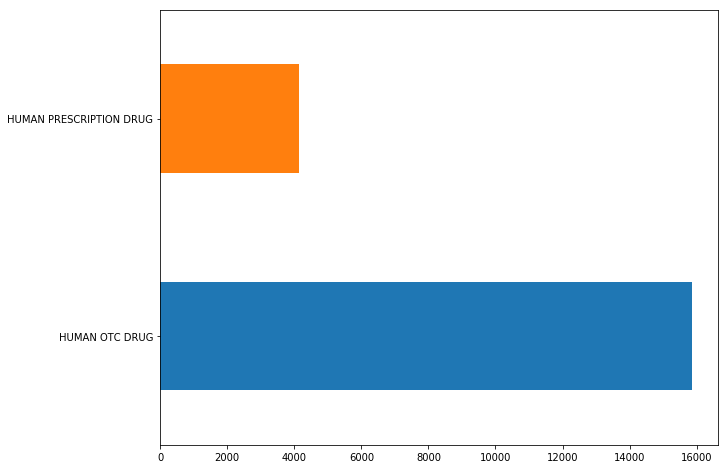

In [36]:
df_openfda['product_type'].value_counts().plot(kind='barh')

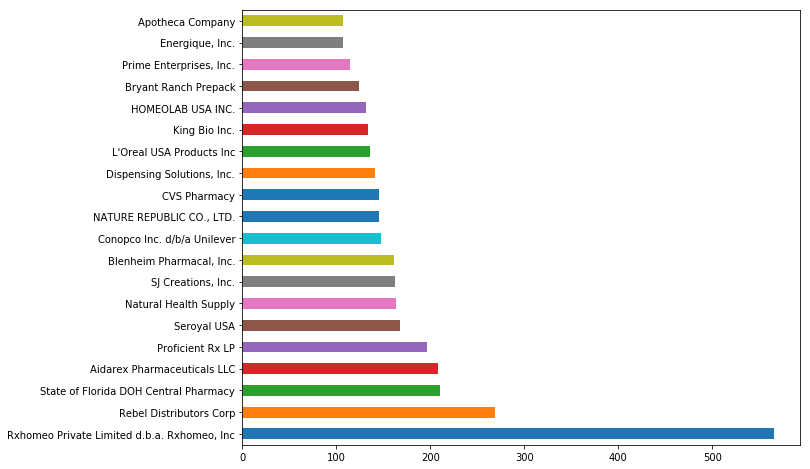

In [40]:
df_openfda['manufacturer_name'].value_counts()[0:20].plot(kind='barh')

In [86]:
grouped = df_openfda.groupby(['product_type', 'manufacturer_name']).count()
grouped.head()

application_number  brand_name  \
product_type   manufacturer_name                                                
HUMAN OTC DRUG 1004LABORATORY                                   7           7   
               21st Century Homeopathics                        0           1   
               21st Century Homeopathics, Inc                   0           1   
               220 LABORATORIES INC                             1           1   
               220 Laboratories Inc                             1           1   

                                               generic_name  \
product_type   manufacturer_name                              
HUMAN OTC DRUG 1004LABORATORY                             7   
               21st Century Homeopathics                  1   
               21st Century Homeopathics, Inc             1   
               220 LABORATORIES INC                       1   
               220 Laboratories Inc                       1   

                                               is_original_packager  nui  \
product_type   manufacturer_name                                           
HUMAN OTC DRUG 1004LABORATORY                                     7    0   
               21st Century Homeopathics                          1    0   
               21st Century Homeopathics, Inc                     1    0   
               220 LABORATORIES INC                               1    0   
               220 Laboratories Inc                               1    0   

                                               original_packager_product_ndc  \
product_type   manufacturer_name                                               
HUMAN OTC DRUG 1004LABORATORY                                              0   
               21st Century Homeopathics                                   0   
               21st Century Homeopathics, Inc                              0   
               220 LABORATORIES INC                                        0   
               220 Laboratories Inc                                        0   

                                               package_ndc  pharm_class_cs  \
product_type   manufacturer_name                                             
HUMAN OTC DRUG 1004LABORATORY                            7               0   
               21st Century Homeopathics                 1               0   
               21st Century Homeopathics, Inc            1               0   
               220 LABORATORIES INC                      1               0   
               220 Laboratories Inc                      1               0   

                                               pharm_class_epc  \
product_type   manufacturer_name                                 
HUMAN OTC DRUG 1004LABORATORY                                0   
               21st Century Homeopathics                     0   
               21st Century Homeopathics, Inc                0   
               220 LABORATORIES INC                          0   
               220 Laboratories Inc                          0   

                                               pharm_class_moa  \
product_type   manufacturer_name                                 
HUMAN OTC DRUG 1004LABORATORY                                0   
               21st Century Homeopathics                     0   
               21st Century Homeopathics, Inc                0   
               220 LABORATORIES INC                          0   
               220 Laboratories Inc                          0   

                                               pharm_class_pe  product_ndc  \
product_type   manufacturer_name                                             
HUMAN OTC DRUG 1004LABORATORY                               0            7   
               21st Century Homeopathics                    0            1   
               21st Century Homeopathics, Inc               0            1   
               220 LABORATORIES INC                         0            1   
  

In [101]:
grouped = df_openfda.groupby(['product_type', 'manufacturer_name']).count()['spl_set_id']
grouped.head()

product_type    manufacturer_name             
HUMAN OTC DRUG  1004LABORATORY                    7
                21st Century Homeopathics         1
                21st Century Homeopathics, Inc    1
                220 LABORATORIES INC              1
                220 Laboratories Inc              1
Name: spl_set_id, dtype: int64

In [102]:
grouped = grouped.unstack('product_type')
grouped.head()

product_type,HUMAN OTC DRUG,HUMAN PRESCRIPTION DRUG
manufacturer_name,,
1004LABORATORY,7.0,NaN
21st Century Homeopathics,1.0,NaN
"21st Century Homeopathics, Inc",1.0,NaN
220 LABORATORIES INC,1.0,NaN
220 Laboratories Inc,1.0,NaN


In [103]:
grouped = grouped.fillna(0)
grouped.head()

product_type,HUMAN OTC DRUG,HUMAN PRESCRIPTION DRUG
manufacturer_name,,
1004LABORATORY,7.0,0.0
21st Century Homeopathics,1.0,0.0
"21st Century Homeopathics, Inc",1.0,0.0
220 LABORATORIES INC,1.0,0.0
220 Laboratories Inc,1.0,0.0


In [104]:
grouped['total_drug'] = grouped['HUMAN OTC DRUG']+grouped['HUMAN PRESCRIPTION DRUG']
grouped.sort_values('total_drug', inplace=True, ascending=False)
grouped.head()

product_type,HUMAN OTC DRUG,HUMAN PRESCRIPTION DRUG,total_drug
manufacturer_name,,,
"Rxhomeo Private Limited d.b.a. Rxhomeo, Inc",565.0,0.0,565.0
Rebel Distributors Corp,41.0,228.0,269.0
State of Florida DOH Central Pharmacy,12.0,198.0,210.0
Aidarex Pharmaceuticals LLC,22.0,186.0,208.0
Proficient Rx LP,28.0,169.0,197.0


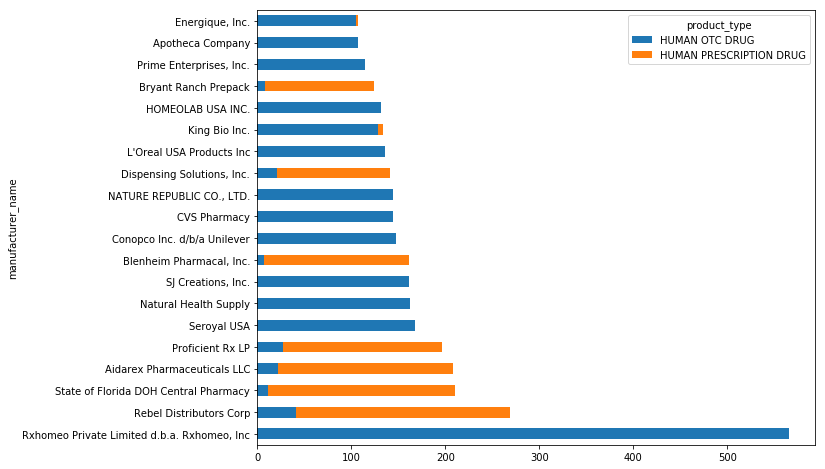

In [107]:
grouped[['HUMAN OTC DRUG','HUMAN PRESCRIPTION DRUG']][0:20].plot(kind='barh', stacked=True)

In [106]:
df_openfda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 21 columns):
application_number               15942 non-null object
brand_name                       20000 non-null object
generic_name                     20000 non-null object
is_original_packager             16920 non-null object
manufacturer_name                20000 non-null object
nui                              711 non-null object
original_packager_product_ndc    3080 non-null object
package_ndc                      20000 non-null object
pharm_class_cs                   657 non-null object
pharm_class_epc                  710 non-null object
pharm_class_moa                  557 non-null object
pharm_class_pe                   277 non-null object
product_ndc                      20000 non-null object
product_type                     20000 non-null object
route                            19999 non-null object
rxcui                            11660 non-null object
spl_id                

In [111]:
print(df_openfda.query('product_type == "HUMAN OTC DRUG"').isnull().sum(axis=1).mean())
print(df_openfda.query('product_type == "HUMAN PRESCRIPTION DRUG"').isnull().sum(axis=1).mean())

7.314932811809981
6.824053988912991


## What do all the columns do?

In [125]:
df[df['abuse'].notna()].iloc[0:5]['abuse']

75     [9.2 Abuse In animal studies, duloxetine did n...
135    [9.2 Abuse Risperidone has not been systematic...
136    [9.2 Abuse Gabapentin does not exhibit affinit...
154    [9.2 Abuse Gabapentin does not exhibit affinit...
225    [9.2 Abuse Abuse and addiction are separate an...
Name: abuse, dtype: object

In [128]:
for c in df.columns:
    print(c)
    print(df[df[c].notna()].iloc[0:5][c])
    print()

abuse
75     [9.2 Abuse In animal studies, duloxetine did n...
135    [9.2 Abuse Risperidone has not been systematic...
136    [9.2 Abuse Gabapentin does not exhibit affinit...
154    [9.2 Abuse Gabapentin does not exhibit affinit...
225    [9.2 Abuse Abuse and addiction are separate an...
Name: abuse, dtype: object

accessories
10162    [CNS Depression Promethazine HCl Suppositories...
14834    [Other Information Store at 20° - 25°C (68°-77...
Name: accessories, dtype: object

active_ingredient
0    [HPUS Active Ingredients Each dose contains eq...
1            [Active ingredient Colloidal oatmeal 43%]
3    [Active ingredient (in each extended-release t...
5    [ACTIVE INGREDIENT Active Ingredient: Hamameli...
6            [Active ingredient Benzoyl Peroxide 2.5%]
Name: active_ingredient, dtype: object

active_ingredient_table
81     [<table width="50%"> <col width="75%" align="l...
87     [<table width="60%"> <col width="75%" align="l...
197    [<table width="60%"> <col width="75%" a

0    [Directions Initially depress pump until prime...
1    [Directions For dispersal in water: Turn warm ...
2    [2 DOSAGE AND ADMINISTRATION Levocetirizine di...
3    [Directions •do not crush, chew, or break tabl...
4    [2 DOSAGE AND ADMINISTRATION •Hypertension: In...
Name: dosage_and_administration, dtype: object

dosage_and_administration_table
9     [<table ID="table1" width="85%"> <caption>Tabl...
11    [<table cellspacing="0" cellpadding="0" border...
12    [<table> <col/> <col/> <tbody> <tr> <td align=...
21    [<table border="1" cellspacing="0" cellpadding...
25    [<table ID="SPLSERV-91c0f56a-c81d-0149-0be3-92...
Name: dosage_and_administration_table, dtype: object

dosage_forms_and_strengths
2     [3 DOSAGE FORMS AND STRENGTHS Levocetirizine D...
4     [3 DOSAGE FORMS AND STRENGTHS Ramipril is supp...
9     [3 DOSAGE FORMS AND STRENGTHS Injection (clear...
24    [3 DOSAGE FORMS AND STRENGTHS White, oval, bic...
36    [3 DOSAGE FORMS AND STRENGTHS Scored Tablets: ...
Name

0                                        [BrightSpark]
1    [Aveeno Baby Eczema Therapy Soothing Bath Trea...
2                     [levocetirizine dihydrochloride]
3                    [Good Neighbor Pharmacy Mucus ER]
4                                           [Ramipril]
Name: openfda.brand_name, dtype: object

openfda.generic_name
0    [ARG NIT, ARSENICUM IOD, HYOSCYAMUS, VERATRUM ...
1                                            [OATMEAL]
2                     [LEVOCETIRIZINE DIHYDROCHLORIDE]
3                                        [GUAIFENESIN]
4                                           [RAMIPRIL]
Name: openfda.generic_name, dtype: object

openfda.is_original_packager
0    [True]
1    [True]
3    [True]
5    [True]
6    [True]
Name: openfda.is_original_packager, dtype: object

openfda.manufacturer_name
0                 [Silver Star Brands]
1    [Johnson & Johnson Consumer Inc.]
2                   [Proficient Rx LP]
3                 [Amerisource Bergen]
4                   [Pr

0    1
1    1
2    1
3    1
4    1
Name: version, dtype: object

veterinary_indications
5055    [5.1 Sedation Carisoprodol Tablets have sedati...
Name: veterinary_indications, dtype: object

warnings
0    [Warnings If symptoms persist or worsen, consu...
1    [Warnings For external use only. When using th...
3    [Warnings Do not use •for children under 12 ye...
5    [WARNINGS Warnings: 1. If the following sympto...
6                     [Warnings For external use only]
Name: warnings, dtype: object

warnings_and_cautions
2     [5 WARNINGS AND PRECAUTIONS 1.Avoid engaging i...
4     [5 WARNINGS AND PRECAUTIONS •Angioedema: incre...
9     [5 WARNINGS AND PRECAUTIONS Accidental Intrava...
14    [Warnings For external use only Do not use on ...
24    [5 WARNINGS AND PRECAUTIONS Skeletal muscle ef...
Name: warnings_and_cautions, dtype: object

warnings_and_cautions_table
24     [<table ID="_RefID088259FE67504F2D867F130C820E...
75     [<table cellpadding="0pt" cellspacing="0pt" wi...
135   